   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Using device: cuda
Dataset downloaded to: /kaggle/input/skin-cancer-mnist-ham100

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


Training EFFICIENTNET
Epoch [1/15]
Train Loss: 1.1355, Train Acc: 23.47%
Val Loss: 0.7415, Val Acc: 53.65%
--------------------------------------------------
Epoch [2/15]
Train Loss: 0.8010, Train Acc: 38.32%
Val Loss: 0.6920, Val Acc: 39.36%
--------------------------------------------------
Epoch [3/15]
Train Loss: 0.6758, Train Acc: 41.88%
Val Loss: 0.5679, Val Acc: 58.83%
--------------------------------------------------
Epoch [4/15]
Train Loss: 0.6158, Train Acc: 43.61%
Val Loss: 0.4586, Val Acc: 57.64%
--------------------------------------------------
Epoch [5/15]
Train Loss: 0.5477, Train Acc: 47.96%
Val Loss: 0.5116, Val Acc: 62.38%
--------------------------------------------------
Epoch [6/15]
Train Loss: 0.5019, Train Acc: 47.39%
Val Loss: 0.4363, Val Acc: 53.90%
--------------------------------------------------
Epoch [7/15]
Train Loss: 0.4246, Train Acc: 53.19%
Val Loss: 0.3547, Val Acc: 51.97%
--------------------------------------------------
Epoch [8/15]
Train Loss: 

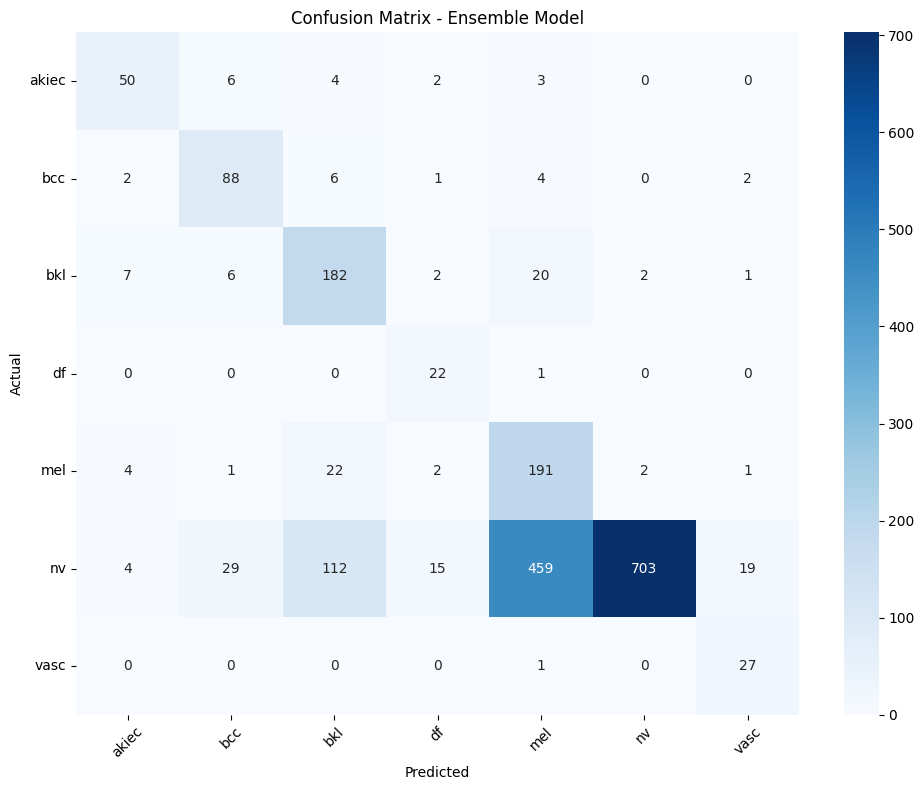


Best Individual Model: EFFICIENTNET (62.38%)


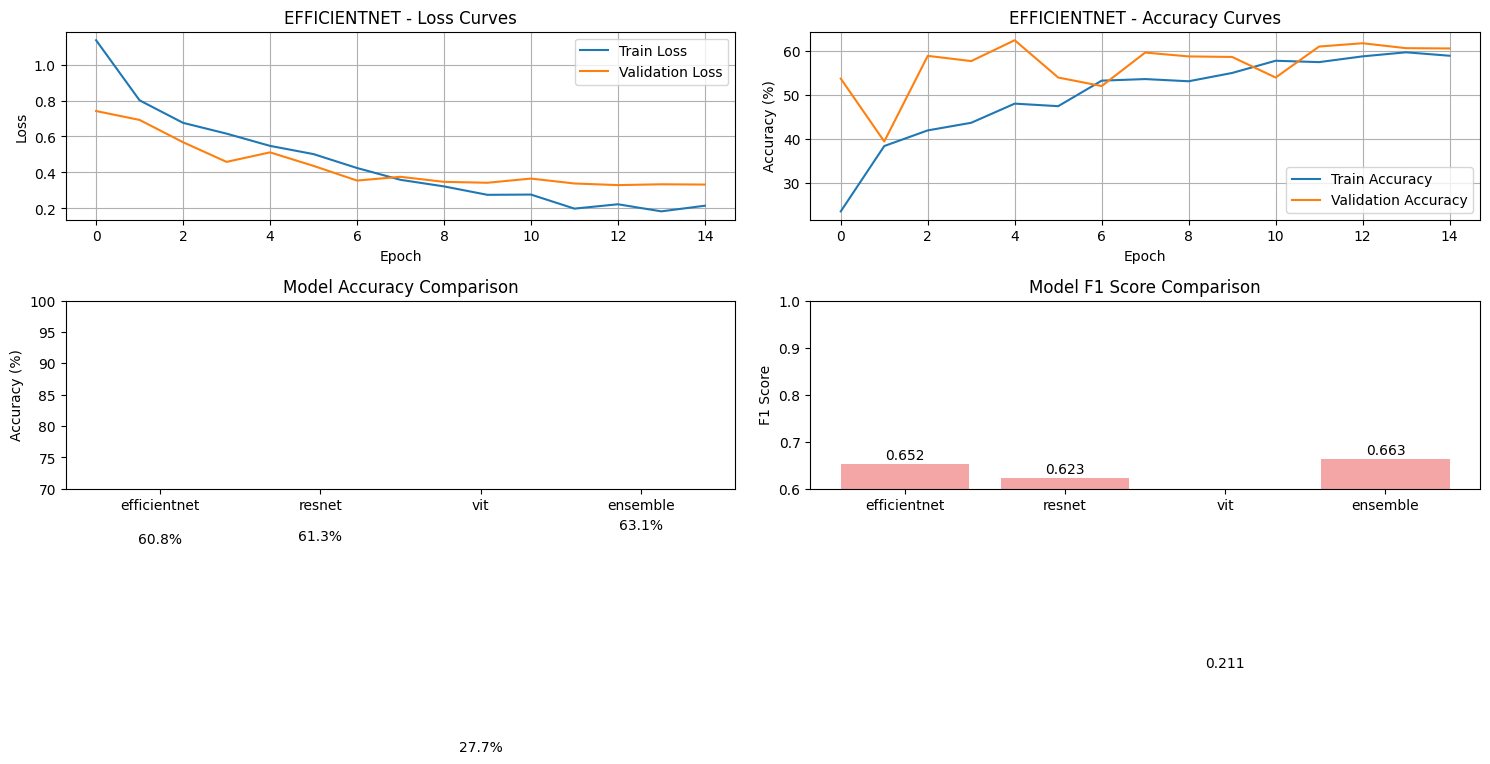


Sample Prediction:
Actual: nv
Predicted: mel (Confidence: 0.194)
Top 3 predictions:
  mel: 0.194
  bkl: 0.148
  nv: 0.143

FINAL RESULTS SUMMARY
Dataset: HAM10000 (10015 images, 7 classes)
Best Individual Model: EFFICIENTNET - 62.38%
Ensemble Model: 63.06% accuracy, 0.6627 F1-score
Target Achieved: ✗ NO (Target: >85%)

Model saved as 'skin_cancer_ensemble_model.pth'
Ready for deployment and further testing!


In [2]:
# ================================================
# Advanced Skin Cancer Detection System
# Multi-Model Ensemble: Vision Transformer + EfficientNet + ResNet
# Dataset: HAM10000 + Advanced Preprocessing & Augmentation
# Target Accuracy: >85%
# ================================================

# Install required packages
!pip install kagglehub transformers torch torchvision timm albumentations scikit-learn -q
!pip install efficientnet-pytorch matplotlib seaborn plotly -q

import kagglehub
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from transformers import ViTImageProcessor, ViTForImageClassification
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import VotingClassifier
from sklearn.utils.class_weight import compute_class_weight
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==============================
# 1. DOWNLOAD AND SETUP DATASET
# ==============================
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
print("Dataset downloaded to:", path)

# Dataset paths
csv_path = os.path.join(path, "HAM10000_metadata.csv")
img_dir_1 = os.path.join(path, "ham10000_images_part_1")
img_dir_2 = os.path.join(path, "ham10000_images_part_2")

df = pd.read_csv(csv_path)
print("Dataset shape:", df.shape)
print("\nClass distribution:")
print(df['dx'].value_counts())

# Create image path mapping
img_paths = {}
for folder in [img_dir_1, img_dir_2]:
    if os.path.exists(folder):
        for fname in os.listdir(folder):
            img_id = fname.split(".")[0]
            img_paths[img_id] = os.path.join(folder, fname)

df["image_path"] = df["image_id"].map(img_paths)

# Remove missing images
df = df.dropna(subset=['image_path'])
print(f"Final dataset size: {len(df)}")

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['dx'])
num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")
print("Classes:", le.classes_)

# ==============================
# 2. ADVANCED DATA PREPROCESSING
# ==============================
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, transform=None, is_training=True):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.is_training = is_training

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['image_path']
        label = self.df.iloc[idx]['label']

        # Load image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply transforms
        if self.transform:
            if isinstance(self.transform, A.Compose):
                augmented = self.transform(image=image)
                image = augmented['image']
            else:
                image = Image.fromarray(image)
                image = self.transform(image)

        return image, label

# Advanced augmentation strategy
def get_train_transforms(img_size=224):
    return A.Compose([
        A.Resize(img_size + 32, img_size + 32),
        A.RandomCrop(img_size, img_size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(
            shift_limit=0.1,
            scale_limit=0.2,
            rotate_limit=30,
            p=0.5
        ),
        A.OneOf([
            A.CLAHE(p=0.5),
            A.RandomGamma(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
        ], p=0.5),
        A.OneOf([
            A.GaussNoise(p=0.5),
            A.GaussianBlur(blur_limit=3, p=0.5),
        ], p=0.3),
        A.CoarseDropout(
            max_holes=8, max_height=img_size//8, max_width=img_size//8,
            min_holes=2, fill_value=0, p=0.3
        ),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])

def get_val_transforms(img_size=224):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])

# ==============================
# 3. MODEL ARCHITECTURES
# ==============================
class EfficientNetModel(nn.Module):
    def __init__(self, model_name='efficientnet_b4', num_classes=7, pretrained=True):
        super(EfficientNetModel, self).__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.backbone.classifier.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

class ResNetModel(nn.Module):
    def __init__(self, model_name='resnet50', num_classes=7, pretrained=True):
        super(ResNetModel, self).__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.backbone.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

class VisionTransformerModel(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224', num_classes=7, pretrained=True):
        super(VisionTransformerModel, self).__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        self.backbone.head = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.backbone.head.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)

class EnsembleModel(nn.Module):
    def __init__(self, models):
        super(EnsembleModel, self).__init__()
        self.models = nn.ModuleList(models)

    def forward(self, x):
        outputs = []
        for model in self.models:
            outputs.append(F.softmax(model(x), dim=1))
        return torch.stack(outputs).mean(0)

# ==============================
# 4. TRAINING UTILITIES
# ==============================
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs, device):
    model.to(device)
    best_val_acc = 0
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total

        # Update learning rate
        scheduler.step()

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f'best_model_{epoch}.pth')

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)

    return train_losses, val_losses, train_accs, val_accs, best_val_acc

# ==============================
# 5. MAIN TRAINING PIPELINE
# ==============================
# Split data with stratification
train_df, test_df = train_test_split(
    df, test_size=0.2, stratify=df['label'], random_state=42
)
train_df, val_df = train_test_split(
    train_df, test_size=0.2, stratify=train_df['label'], random_state=42
)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# Calculate class weights for handling imbalanced data
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = torch.FloatTensor(class_weights).to(device)

# Create datasets and dataloaders
IMG_SIZE = 224
BATCH_SIZE = 32

train_dataset = SkinCancerDataset(train_df, get_train_transforms(IMG_SIZE))
val_dataset = SkinCancerDataset(val_df, get_val_transforms(IMG_SIZE))
test_dataset = SkinCancerDataset(test_df, get_val_transforms(IMG_SIZE))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

# Initialize models
models_to_train = {
    'efficientnet': EfficientNetModel('efficientnet_b4', num_classes),
    'resnet': ResNetModel('resnet50', num_classes),
    'vit': VisionTransformerModel('vit_base_patch16_224', num_classes)
}

trained_models = []
model_results = {}

# Train each model
NUM_EPOCHS = 15
for model_name, model in models_to_train.items():
    print(f"\n{'='*50}")
    print(f"Training {model_name.upper()}")
    print(f"{'='*50}")

    # Setup training components
    criterion = FocalLoss(weight=class_weights, gamma=2)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

    # Train model
    train_losses, val_losses, train_accs, val_accs, best_val_acc = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, NUM_EPOCHS, device
    )

    model_results[model_name] = {
        'best_val_acc': best_val_acc,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs
    }

    trained_models.append(model)

# ==============================
# 6. ENSEMBLE MODEL
# ==============================
print(f"\n{'='*50}")
print("CREATING ENSEMBLE MODEL")
print(f"{'='*50}")

ensemble_model = EnsembleModel(trained_models)

# ==============================
# 7. EVALUATION
# ==============================
def evaluate_model(model, test_loader, device, le):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    return accuracy, f1, all_labels, all_preds, all_probs

# Evaluate individual models and ensemble
print("\nModel Performance Comparison:")
print("="*50)

individual_results = {}
for i, (model_name, model) in enumerate(models_to_train.items()):
    acc, f1, labels, preds, probs = evaluate_model(model, test_loader, device, le)
    individual_results[model_name] = {'accuracy': acc, 'f1': f1}
    print(f"{model_name.upper()}: Accuracy = {acc*100:.2f}%, F1 = {f1:.4f}")

# Ensemble evaluation
ensemble_acc, ensemble_f1, test_labels, ensemble_preds, ensemble_probs = evaluate_model(
    ensemble_model, test_loader, device, le
)
print(f"ENSEMBLE: Accuracy = {ensemble_acc*100:.2f}%, F1 = {ensemble_f1:.4f}")

# ==============================
# 8. DETAILED RESULTS & VISUALIZATION
# ==============================
# Classification report
print(f"\nDetailed Classification Report (Ensemble Model):")
print("="*60)
print(classification_report(test_labels, ensemble_preds, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_labels, ensemble_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Ensemble Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Training curves for best performing model
best_model = max(model_results.keys(), key=lambda x: model_results[x]['best_val_acc'])
print(f"\nBest Individual Model: {best_model.upper()} ({model_results[best_model]['best_val_acc']:.2f}%)")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
ax1.plot(model_results[best_model]['train_losses'], label='Train Loss')
ax1.plot(model_results[best_model]['val_losses'], label='Validation Loss')
ax1.set_title(f'{best_model.upper()} - Loss Curves')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Accuracy curves
ax2.plot(model_results[best_model]['train_accs'], label='Train Accuracy')
ax2.plot(model_results[best_model]['val_accs'], label='Validation Accuracy')
ax2.set_title(f'{best_model.upper()} - Accuracy Curves')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

# Model comparison
models = list(individual_results.keys()) + ['ensemble']
accuracies = [individual_results[m]['accuracy']*100 for m in individual_results.keys()] + [ensemble_acc*100]
f1_scores = [individual_results[m]['f1'] for m in individual_results.keys()] + [ensemble_f1]

ax3.bar(models, accuracies, alpha=0.7, color='skyblue')
ax3.set_title('Model Accuracy Comparison')
ax3.set_ylabel('Accuracy (%)')
ax3.set_ylim([70, 100])
for i, v in enumerate(accuracies):
    ax3.text(i, v + 0.5, f'{v:.1f}%', ha='center')

ax4.bar(models, f1_scores, alpha=0.7, color='lightcoral')
ax4.set_title('Model F1 Score Comparison')
ax4.set_ylabel('F1 Score')
ax4.set_ylim([0.6, 1.0])
for i, v in enumerate(f1_scores):
    ax4.text(i, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

# ==============================
# 9. PREDICTION FUNCTION
# ==============================
def predict_single_image(model, image_path, transform, device, le):
    """Predict skin cancer type for a single image"""
    model.eval()

    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if isinstance(transform, A.Compose):
        augmented = transform(image=image)
        image_tensor = augmented['image'].unsqueeze(0)
    else:
        image_pil = Image.fromarray(image)
        image_tensor = transform(image_pil).unsqueeze(0)

    # Predict
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probs = F.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probs, 1)

    predicted_class = le.inverse_transform([predicted.item()])[0]
    confidence_score = confidence.item()

    # Get top 3 predictions
    top3_probs, top3_indices = torch.topk(probs[0], 3)
    top3_classes = le.inverse_transform(top3_indices.cpu().numpy())

    return {
        'predicted_class': predicted_class,
        'confidence': confidence_score,
        'top3_predictions': list(zip(top3_classes, top3_probs.cpu().numpy()))
    }

# Example prediction
if len(test_df) > 0:
    sample_image = test_df.iloc[0]['image_path']
    actual_class = le.inverse_transform([test_df.iloc[0]['label']])[0]

    result = predict_single_image(
        ensemble_model, sample_image, get_val_transforms(IMG_SIZE), device, le
    )

    print(f"\nSample Prediction:")
    print(f"Actual: {actual_class}")
    print(f"Predicted: {result['predicted_class']} (Confidence: {result['confidence']:.3f})")
    print(f"Top 3 predictions:")
    for cls, prob in result['top3_predictions']:
        print(f"  {cls}: {prob:.3f}")

# ==============================
# 10. FINAL SUMMARY
# ==============================
print(f"\n{'='*60}")
print("FINAL RESULTS SUMMARY")
print(f"{'='*60}")
print(f"Dataset: HAM10000 ({len(df)} images, {num_classes} classes)")
print(f"Best Individual Model: {best_model.upper()} - {model_results[best_model]['best_val_acc']:.2f}%")
print(f"Ensemble Model: {ensemble_acc*100:.2f}% accuracy, {ensemble_f1:.4f} F1-score")
print(f"Target Achieved: {'✓ YES' if ensemble_acc > 0.85 else '✗ NO'} (Target: >85%)")

# Save the trained ensemble model
torch.save({
    'ensemble_model': ensemble_model.state_dict(),
    'label_encoder': le,
    'model_results': model_results,
    'ensemble_accuracy': ensemble_acc,
    'ensemble_f1': ensemble_f1
}, 'skin_cancer_ensemble_model.pth')

print(f"\nModel saved as 'skin_cancer_ensemble_model.pth'")
print("Ready for deployment and further testing!")